In [22]:
import numpy as np
import os
import random
import cv2
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, MaxPooling2D
from keras import metrics
from keras.models import model_from_json
from keras import models
from keras import backend as K
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

In [3]:
total_classes = 96
line_folder = "../line_data"
op_folder = "./result/line"

X_train = np.load(line_folder + "/x_train.npy")
y_train = np.load(line_folder + "/y_train.npy")
X_test = np.load(line_folder + "/x_test.npy")
y_test = np.load(line_folder + "/y_test.npy")

# X_train = X_train[:1000]
# y_train = y_train[:1000]
# X_test = X_test[:1000]
# y_test = y_test[:1000]

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(57600, 28, 28, 3) (38400, 28, 28, 3) (57600, 96) (38400, 96)


In [4]:
X_train = X_train.reshape(57600, 28, 28, 3)
X_test = X_test.reshape(38400, 28, 28, 3)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(57600, 28, 28, 3) (38400, 28, 28, 3) (57600, 96) (38400, 96)


In [20]:
model = Sequential()
model.add(Conv2D(32, kernel_size=7, strides=1, activation="relu", input_shape=(28,28,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(total_classes, activation="softmax"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.output_shape
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 22, 22, 32)        4736      
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 22, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              3965952   
_________________________________________________________________
dense_4 (Dense)              (None, 96)                98400     
Total params: 4,069,216
Trainable params: 4,069,152
Non-trainable params: 64
_________________________________________________________________

Train on 57600 samples, validate on 38400 samples
Epoch 1/4
57600/57600 [==============================] - 87s 2ms/step - loss: 1.5421 - acc: 0.6185 - val_loss: 0.4969 - val_acc: 0.8326
Epoch 2/4
57600/57600 [==============================] - 88s 2ms/step - loss: 0.1831 - acc: 0.9416 - val_loss: 0.1600 - val_acc: 0.9486
Epoch 3/4
57600/57600 [==============================] - 89s 2ms/step - loss: 0.0787 - acc: 0.9768 - val_loss: 0.1160 - val_acc: 0.9645
Epoch 4/4
57600/57600 [==============================] - 93s 2ms/step - loss: 0.0580 - acc: 0.9840 - val_loss: 0.0899 - val_acc: 0.9734


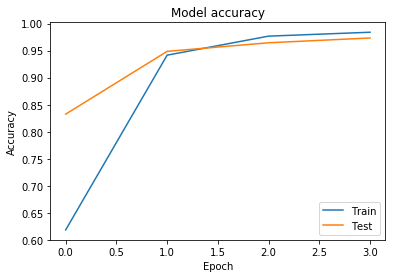

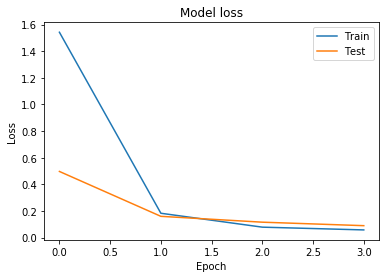

In [6]:
if not os.path.exists(op_folder):
    os.makedirs(op_folder)
    
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, batch_size=300)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig(op_folder + "/accuracy.png", bbox_inches='tight')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig(op_folder + "/loss.png", bbox_inches='tight')
plt.show()

In [7]:
# Final evaluation of the model
y_pred = model.predict(X_test)


In [8]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
fscore = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')
precision = precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')
recall = recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

np.savetxt(op_folder + "/confusion_matrix.txt", cm, fmt="%d")
with open(op_folder + "/scores.txt", 'w') as the_file:
    the_file.write("Accuracy " + str(accuracy) + 
                  "\nPrecision " + str(precision) + 
                  "\nRecall " + str(recall) +
                  "\nFscore " + str(fscore))

print ("Accuracy " + str(accuracy) + 
      "\nPrecision " + str(precision) + 
      "\nRecall " + str(recall) +
      "\nFscore " + str(fscore))

Accuracy 0.973359375
Precision 0.9743364554465668
Recall 0.9733593749999999
Fscore 0.9734090425322162


In [9]:
def showVisualizationActivation(imageNoAsInput):
    
    plt.title('Input Image')
    plt.imshow(np.squeeze(X_train[imageNoAsInput]), cmap='gray')
    
    
    img_tensor = X_train[imageNoAsInput]
    img_tensor = np.expand_dims(img_tensor, axis=0)

    layer_outputs = [layer.output for layer in model.layers[:3]] # Extracts the outputs of the top 4 layers
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

    activations = activation_model.predict(img_tensor) 
    
    layer_names = []
    for layer in model.layers[:3]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

#     print(layer_names)

    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix

#         print(size,n_cols, images_per_row)

        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')
#         plt.savefig(str(imageNoAsInput) + layer_name+"_grid.jpg", bbox_inches='tight')

In [12]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [41]:
#---------------------------------------------------------------------------------------------------
#Utility function for generating patterns for given layer starting from empty input image and then 
#applying Stochastic Gradient Ascent for maximizing the response of particular filter in given layer
#---------------------------------------------------------------------------------------------------

def generate_pattern(layer_name, filter_index, size=28):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(80):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

# layer_output = model.input
# print(layer_output.shape)

In [68]:
#------------------------------------------------------------------------------------------
#Generating convolution layer filters for intermediate layers using above utility functions
#------------------------------------------------------------------------------------------

def showVisualizationConvnet(layer_name):
    size = 28
    margin = 1

    results = np.zeros((4 * size + 7 * margin, 8 * size + 7 * margin, 3))

    
    fig = plt.figure(figsize=(20, 20))
    cnt = 1
    for i in range(8):
        for j in range(4):
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[vertical_start: vertical_end, horizontal_start: horizontal_end, 0:3] = filter_img
            fig.add_subplot(4,8,cnt)
            cnt += 1
            plt.imshow(filter_img)
    
    plt.title(layer_name)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.5)
    plt.show()

# showVisualizationConvnet('conv2d_2')

In [70]:
def showVisualizationHeatMap(inputImageNo, classs, noFilters, layer_name, outputIMG):
    plt.figure()
    plt.title('Input Image')
    plt.imshow(np.squeeze(X_train[inputImageNo]), cmap='gray')


    x = X_train[inputImageNo]
    x = np.expand_dims(x,axis=0)
    # x = preprocess_input(x)

    preds = model.predict(x)

    # classs is the class of input image
    image_output = model.output[:,classs]
    last_conv_layer = model.get_layer(layer_name)

    grads = K.gradients(image_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # #noFilters is the number of filters/channels in 'convolution' layer
    for i in range(noFilters):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.figure()
    plt.title(layer_name)
    plt.imshow(heatmap)

    # plt.imshow(heatmap)
    # plt.savefig(heatmap)

    # #Using cv2 to superimpose the heatmap on original image to clearly illustrate activated portion of image
    img = X_train[0]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    
    cv2.imwrite(outputIMG,cv2.resize(superimposed_img,(500,500)))
    # plt.figure()
    # plt.title("SuperImposed Image")
    # # plt.grid(False)
    # plt.imshow(superimposed_img)

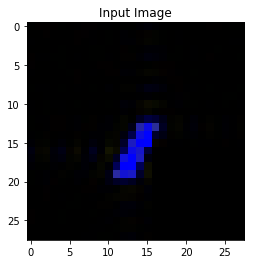

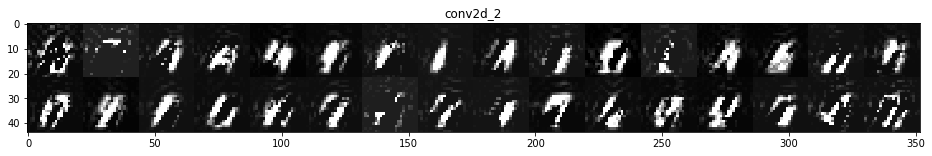

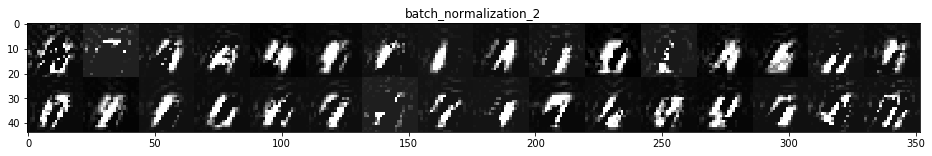

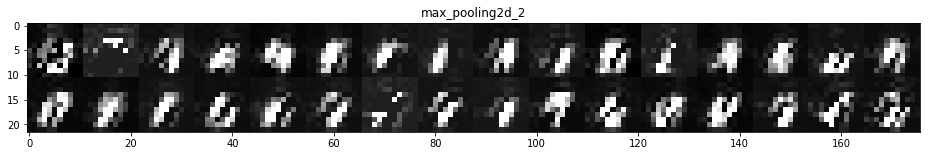

In [33]:
showVisualizationActivation(random.randint(0,57000))

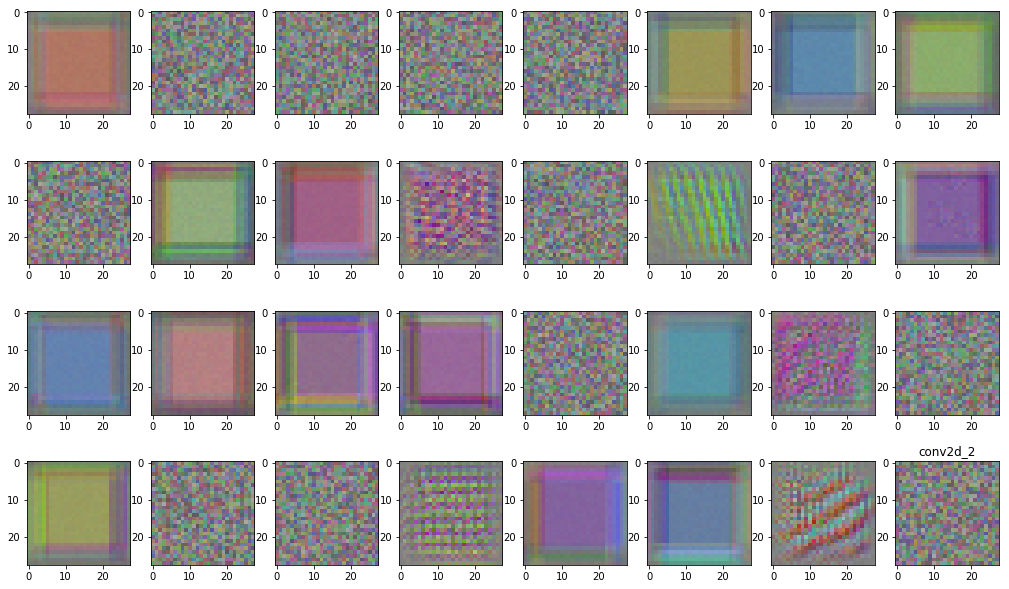

In [69]:
layer_name = 'conv2d_2'
showVisualizationConvnet(layer_name)

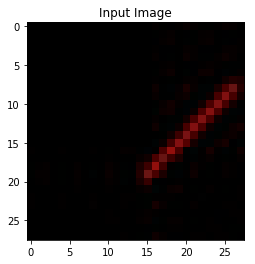

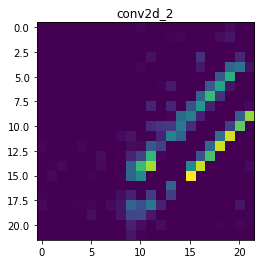

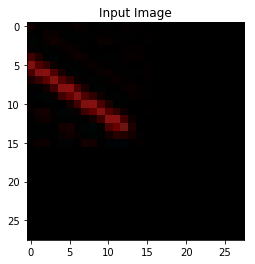

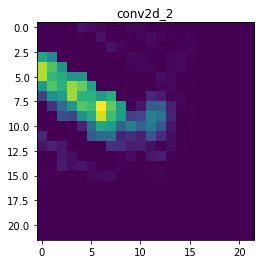

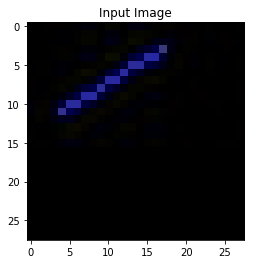

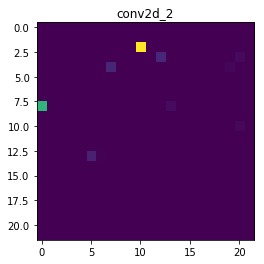

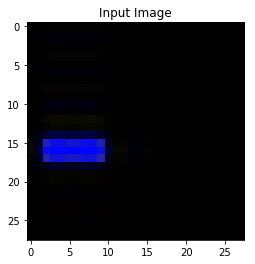

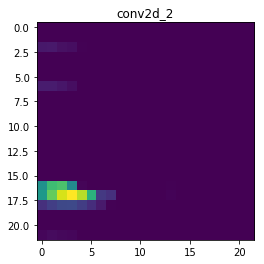

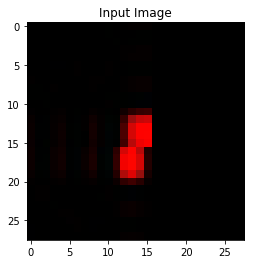

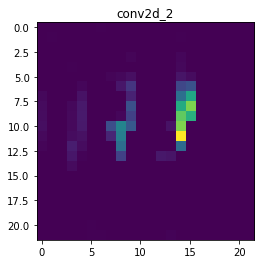

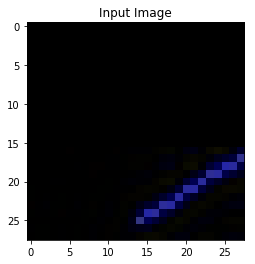

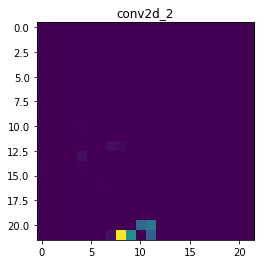

In [35]:
for i in range(6):
    showVisualizationHeatMap(random.randint(0,57000),classs = 1,noFilters = 32, layer_name = 'conv2d_2',outputImg="imgSeqLine"+str(i)+".png")